In [1]:
import re
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [2]:
import pandas as pd
filepath = '/Users/seeni-2328/Documents/Seeni/Datasets/kaggle/sentiment-analysis-on-movie/train.tsv'
df = pd.read_csv(filepath, sep = '\t', error_bad_lines=False)

In [3]:
print('Shape of dataset ',df.shape)
print(df.columns)
print('No. of unique classes: ',len(set(df['Sentiment'])))

Shape of dataset  (156060, 4)
Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')
No. of unique classes:  5


In [4]:
macronum=sorted(set(df['Sentiment']))
print(macronum)
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

df['Sentiment']=df['Sentiment'].apply(fun)

[0, 1, 2, 3, 4]


In [5]:
data_train = df.head(1000)
data_train['message'] = data_train['Phrase']


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
data_train['message'][0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [7]:
from bs4 import BeautifulSoup
texts = []
label = []
for idx in range(data_train.message.shape[0]):
#     text = BeautifulSoup(data_train.message[idx])
#     texts.append(clean_str(str(text.get_text().encode())))
    texts.append(clean_str(data_train.message[idx]))

for idx in data_train['Sentiment']:
    label.append(idx)

In [9]:
len(texts)

1000

In [10]:
from keras.preprocessing.text import Tokenizer
MAX_NB_WORDS = 20000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Using TensorFlow backend.


Number of Unique Tokens 363


In [11]:
print(len(sequences))
print(len(word_index))

1000
363


In [12]:
for i in range(2) :
    print(sequences[i])
    print(texts[i])
    print()

[2, 339, 3, 313, 234, 1, 188, 8, 40, 7, 12, 9, 1, 86, 7, 314, 12, 9, 1, 164, 46, 3, 14, 165, 130, 23, 87, 3, 14, 59, 6, 15, 3, 2, 24]
a series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .

[2, 339, 3, 313, 234, 1, 188, 8, 40, 7, 12, 9, 1, 86]
a series of escapades demonstrating the adage that what is good for the goose



In [26]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
MAX_SEQUENCE_LENGTH = 500
VALIDATION_SPLIT = 0.2
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(label))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
print('x_train shape :', x_train.shape)
print('y_train shape :', y_train.shape)
print('x_val shape :', x_val.shape)
print('y_val shape :', y_val.shape)

Shape of Data Tensor: (1000, 500)
Shape of Label Tensor: (1000, 5)
x_train shape : (800, 500)
y_train shape : (800, 5)
x_val shape : (200, 500)
y_val shape : (200, 5)


In [18]:
embeddings_index = {}
glove_path = '/Users/seeni-2328/Documents/Seeni/Datasets/global-datasets/glove/glove.6B/glove.6B.100d.txt'
f = open(glove_path,encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [20]:
EMBEDDING_DIM = 100
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
embedding_matrix.shape

(364, 100)

In [35]:
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [43]:
from keras.layers import Embedding
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)


In [45]:
from keras.layers import Input
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
# from keras.callbacks import ModelCheckpoint
# import matplotlib.pyplot as plt
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)


In [47]:
print(sequence_input.shape)
print(embedded_sequences.shape)

(?, 500)
(?, 500, 100)


In [50]:
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
print(l_cov1.shape)

(?, 496, 128)


In [51]:
l_pool1 = MaxPooling1D(5)(l_cov1)
print(l_pool1.shape)

(?, 99, 128)


In [52]:
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
print(l_cov2.shape)

(?, 95, 128)


In [55]:
l_pool2 = MaxPooling1D(5)(l_cov2)
print(l_pool2.shape)

(?, 19, 128)


In [56]:
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
print(l_cov3.shape)

(?, 15, 128)


In [57]:
l_pool3 = MaxPooling1D(15)(l_cov3)  # global max pooling
print(l_pool3.shape)

(?, 1, 128)


In [68]:
l_flat = Flatten()(l_pool3)
print(l_flat.shape)

(?, ?)


In [69]:
l_dense = Dense(128, activation='relu')(l_flat)
print(l_dense.shape)

(?, 128)


In [70]:
preds = Dense(len(macronum), activation='softmax')(l_dense)
print(preds.shape)

(?, 5)


In [71]:
model = Model(sequence_input, preds)

In [72]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [73]:
print("Simplified convolutional neural network")
model.summary()

Simplified convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 100)          36400     
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 496, 128)          64128     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 99, 128)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 95, 128)           82048     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 19, 128)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 

In [76]:
from keras.callbacks import ModelCheckpoint
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

In [78]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=2,callbacks=[cp])

Train on 800 samples, validate on 200 samples
Epoch 1/15
800/800 [==============================] - 4s 5ms/step - loss: 0.5965 - acc: 0.8350 - val_loss: 1.9120 - val_acc: 0.6850

Epoch 00001: val_acc did not improve from 0.72000
Epoch 2/15
800/800 [==============================] - 4s 5ms/step - loss: 0.6556 - acc: 0.8438 - val_loss: 2.2123 - val_acc: 0.6900

Epoch 00002: val_acc did not improve from 0.72000
Epoch 3/15
800/800 [==============================] - 4s 5ms/step - loss: 0.5560 - acc: 0.8438 - val_loss: 2.0109 - val_acc: 0.6900

Epoch 00003: val_acc did not improve from 0.72000
Epoch 4/15
800/800 [==============================] - 4s 5ms/step - loss: 0.5854 - acc: 0.8425 - val_loss: 1.7358 - val_acc: 0.6950

Epoch 00004: val_acc did not improve from 0.72000
Epoch 5/15
800/800 [==============================] - 4s 5ms/step - loss: 0.7343 - acc: 0.8550 - val_loss: 3.1854 - val_acc: 0.6800

Epoch 00005: val_acc did not improve from 0.72000
Epoch 6/15
800/800 [===================

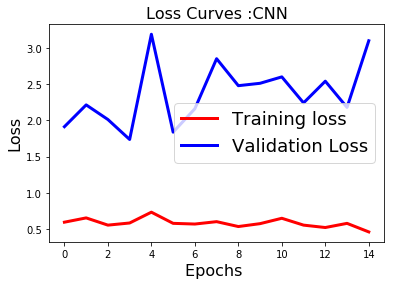

In [83]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')


plt.show()

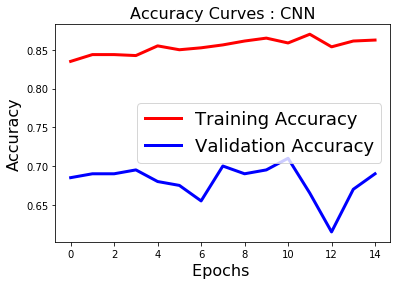

In [84]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

In [89]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [85]:
from PIL import Image
display(Image.open('cnn_model.png'))

FileNotFoundError: [Errno 2] No such file or directory: 'cnn_model.png'

In [23]:
for i in range(2) :
    print(sequences[i])
    print(texts[i])
    print(data[i])
    print()

[2, 339, 3, 313, 234, 1, 188, 8, 40, 7, 12, 9, 1, 86, 7, 314, 12, 9, 1, 164, 46, 3, 14, 165, 130, 23, 87, 3, 14, 59, 6, 15, 3, 2, 24]
a series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
500 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0